In [1]:
import numpy
import pylab

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE

from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library.standard_gates import XGate
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter

from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler, Session, Estimator

In [15]:
# Your can find your API keys here: https://cloud.ibm.com/iam/apikeys
MY_IBM_CLOUD_API_KEY = "?"
# You can find your Cloud Resource Name instances here: https://cloud.ibm.com/quantum/instances
MY_IBM_CLOUD_CRN = "MUST_TO_ADD_YOUR_CRN_HERE!"

In [16]:
# # Save cloud channel credentials locally in $HOME/.qiskit/qiskit-ibm.json (you'll need to run this only once!). 
QiskitRuntimeService.save_account(channel="ibm_cloud", token=MY_IBM_CLOUD_API_KEY, instance=MY_IBM_CLOUD_CRN, overwrite=True)

In [17]:
# Load a previously saved account and optionally select a 
# different hub/group/project in case you have access
provider = IBMProvider(instance="ibm-q/open/main")

In [19]:
# the ibmq_qasm_simulator works like a real quantum device, in particular the specified number of shots are taken
# during simulation unlike other simulators like for example  state vector simulator where the ideal result is calculated
backend = provider.get_backend("ibmq_qasm_simulator")

In [20]:
# Qiskit Runtime: is a programming model and containerized environment for deploying quantum programs, designed to reduce the 
# computational cycle time between quantum and classical computers. For details please checkout following resources
# https://medium.com/qiskit/so-what-is-qiskit-runtime-anyway-c78aecf3742
# https://qiskit.org/ecosystem/ibm-runtime/
#service = QiskitRuntimeService(channel="ibm_quantum")
service = QiskitRuntimeService(channel="ibm_cloud", instance=MY_IBM_CLOUD_CRN) # ADD YOUR CRN HERE !!!
backend = service.backend(backend.name)

In [22]:
# The solver is the algorithm through which the ground state is computed. 
# This solver in particular computes the molecule ground state classically
npmes = NumPyMinimumEigensolver()

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

classical_result = npmes.compute_minimum_eigenvalue(operator=H2_op)
print("The ground state electronic energy computed classically is: ", classical_result.eigenvalue)

The ground state electronic energy computed classically is:  -1.8572750302023824


In [23]:
# initializing an instance of qiskit_ibm_runtime.Sampler rather than 
# qiskit.primitives.Sampler to use Qiskit Runtime’s implementation of the Sampler
options = Options(environment={"log_level": "INFO"})
# optimization_level=3 adds dynamical decoupling
options.optimization_level=3
# resilience_level=1 adds readout error mitigation
options.resilience_level=0
options.execution.shots = 100000

In [24]:
counts = []
values = []

def print_and_store_intermediate_result(eval_count, parameters, mean, std):
    print("Eval count: ", eval_count, "Mean value: ", mean)
    counts.append(eval_count)
    values.append(mean)
    
with Session(service=service, backend=backend, max_time="10s") as session:
    # Qiskit runtimes uses one of two primitives a Sampler for sampling probabilities distributions or an Estimator
    estimator = Estimator(options=options)
    # the classical optimizer algorithm (other options exist here)
    optimizer = COBYLA(maxiter=100)
    # the ansatz is a just a guess for the wavefunction of the molecule whose parameters
    # will be optimized by VQE class in order to find the valye of the ground state energy
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    
    vqe = VQE(estimator, ansatz, optimizer, callback=print_and_store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)

Eval count:  1 Mean value:  -1.4655708675513233
Eval count:  2 Mean value:  -1.1860374834917962
Eval count:  3 Mean value:  -1.5818423826474544
Eval count:  4 Mean value:  -1.1492115644967023
Eval count:  5 Mean value:  -1.1286897234581772
Eval count:  6 Mean value:  -1.457394237008049
Eval count:  7 Mean value:  -1.5355979159327142
Eval count:  8 Mean value:  -1.3136606713525836
Eval count:  9 Mean value:  -1.7956218937455874
Eval count:  10 Mean value:  -1.5789049011496075
Eval count:  11 Mean value:  -1.741211591207278
Eval count:  12 Mean value:  -1.8483135381654883
Eval count:  13 Mean value:  -1.8219438558825876
Eval count:  14 Mean value:  -1.8215762840128313
Eval count:  15 Mean value:  -1.7610177340436057
Eval count:  16 Mean value:  -1.797377283121053
Eval count:  17 Mean value:  -1.8149112975564903
Eval count:  18 Mean value:  -1.839263332604623
Eval count:  19 Mean value:  -1.8495692731894458
Eval count:  20 Mean value:  -1.836786616604074
Eval count:  21 Mean value:  -1.85

In [25]:
print("The ground state electronic energy obtained using a quantum algorithm is: ", result.eigenvalue)

The ground state electronic energy obtained using a quantum algorithm is:  -1.8573549646548657


Text(0.5, 1.0, 'Convergence of VQE for the H2 molecule')

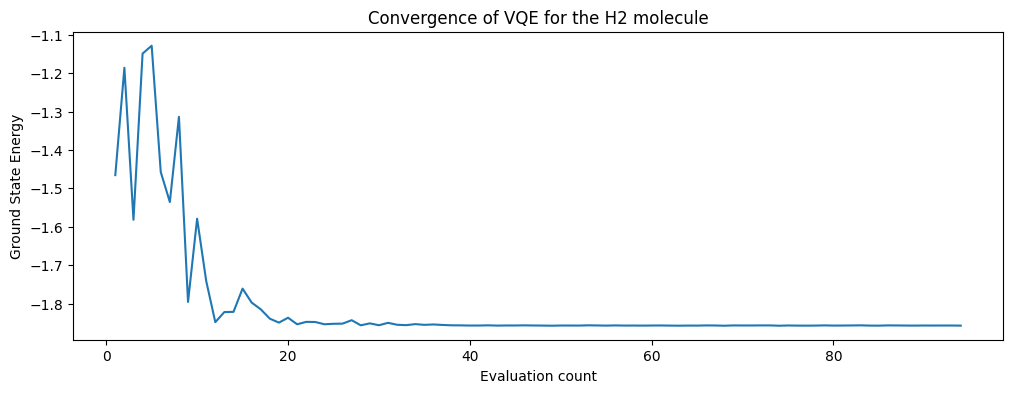

In [28]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Evaluation count")
pylab.ylabel("Ground State Energy")
pylab.title("Convergence of VQE for the H2 molecule")

In [27]:
from qiskit.tools.jupyter import *

%qiskit_version_table